# Midterm (MACS 30100), February 5, 2018
### Kevin Sun
You will have an hour and thirty minutes to take this exam.
1. Put your name in the space provided above (without the brackets).
2. Download this notebook and accompanying data `LenderDataLong.dta`.
3. The class will disconnect their wi-fi and begin taking the exam.
4. The exam is open computer, closed internet, open note.
5. Once you are done, you will signal to a TA or instructor to come over and monitor while you reconnect to the internet and upload your edited notebook to Canvas.

Remember that you must clearly indicate your answers to all questions below. We will give partial credit for partially correct answers. The midterm is worth 20 points (2 problem sets).

## The data
This two exercises of this midterm and all their respective subparts will use the `LenderData.csv` dataset, which contains observations of characteristics on short-term, high interest rate, lender information. You are not to use this data outside of this class. It is a jittered and randomized version of a dataset used in a published research paper.

Each observation contains characteristics of a particular lender location Read it into Python using the `pandas.read_csv()` command. The variables are the following:

* `avgrate`: average annualized interest rate of all loans in percentage points (235 = two hundred and thirty five percent)
* `numstores`: number of other stores owned by the same owner (measure of size)
* `defrate`: default rate on loans from that store during 2010
* `pdrad3`: number of payday lenders within a three-mile radius of the store (measure of competition)
* `pnrad3`: number of pawn lenders within a three-mile radius of the store (measure of competition)
* `totrad3`: total number of other lenders within a three-mile radius of the store (measure of competition)
* `unrt_zip`: unemployment rate in the zip code of the store
* `medtotinc2010`: median total household income in the zip code of the store
* `edbachplus_zip`: average education level in years of schooling of heads of household in the zip code of the store
* `pop_zip`: population in zip code of the store
* `mdage_zip`: median age (in years) in zip code of the store
* `pctblk2_zip`: percent of the population that is black in the zip code of the store in percentage points (2.2=two point two percent)

In [63]:
# import relevant libraries
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt # for optimization 
import statsmodels.api as sm # for OLS

#KNN & Logit
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams

%matplotlib notebook

In [64]:
# read in the data
lender_data = pd.read_csv("LenderData.csv")
lender_data.head(10)

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7
5,521.429993,23,28.148958,21,15,38,7.5,27502.00000,22.3,28936,30.8,2.7
6,521.429993,23,34.020618,21,15,38,10.8,24939.33398,14.8,33297,28.9,5.6
7,521.429993,23,22.362869,15,7,23,7.4,34078.60938,23.5,35603,29.1,1.6
8,521.429993,23,25.284090,18,6,24,9.9,23155.38867,11.1,24869,27.5,5.1
9,521.429993,23,37.777779,28,14,43,9.9,23155.38867,11.1,24869,27.5,5.1


## 1. Using the distributions of interest rates and median income (10 points)

1A) [2 points] Create a plot of the histogram of high interest rate lenders interest rates `avgrate`. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into $N$ categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

In [65]:
# put avgrate into a variable
avg_rate = lender_data["avgrate"]

<IPython.core.display.Javascript object>


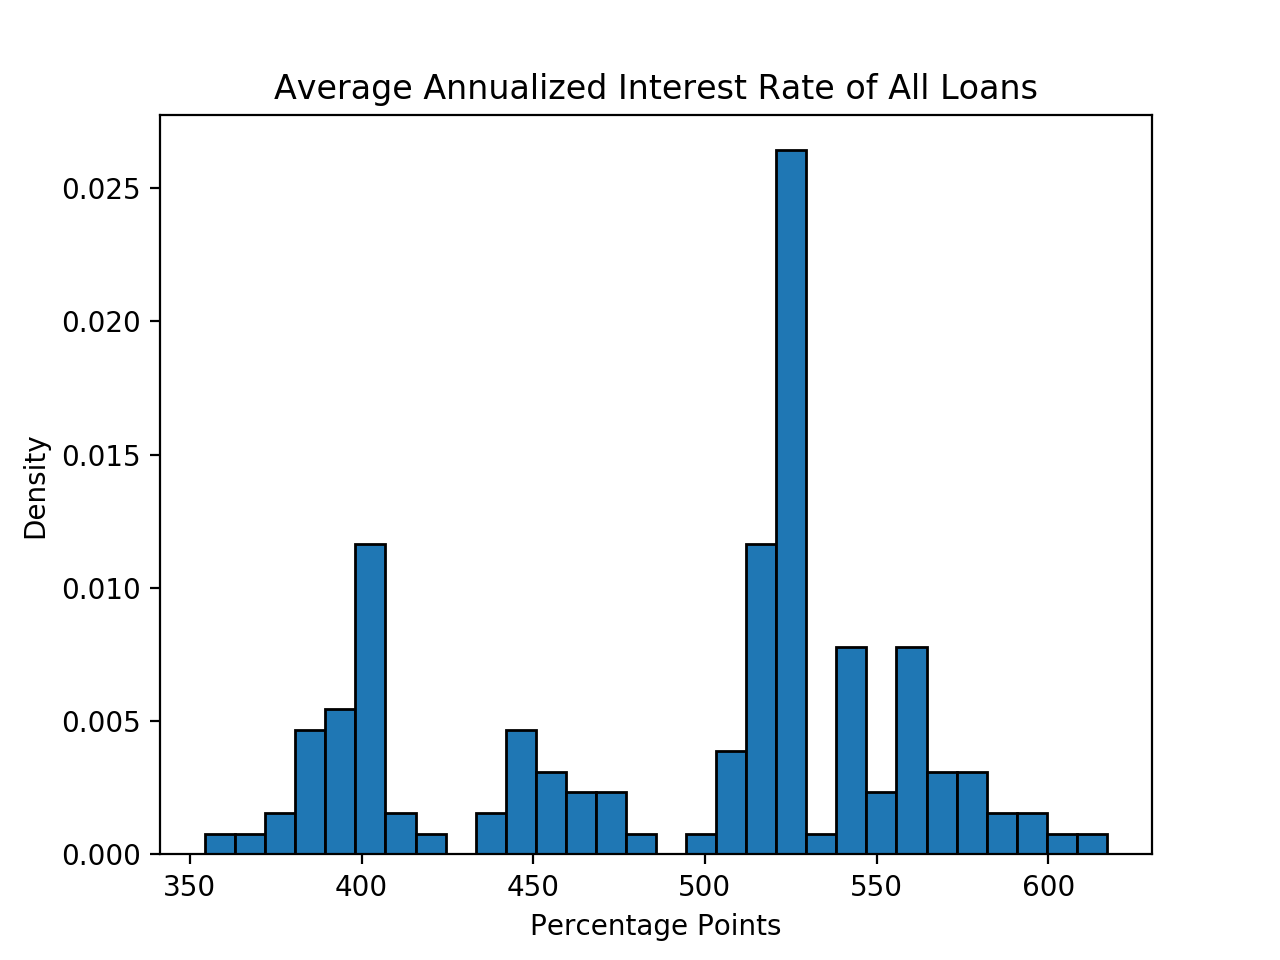

In [66]:
# histogram of avg_rate variable 
plt.hist(avg_rate, bins=30, edgecolor="black", normed=True)
plt.title("Average Annualized Interest Rate of All Loans")
plt.xlabel("Percentage Points")
plt.ylabel("Density")

If we were to group the lenders into N categories, then N=4 would seem like a natural way to group the data. There appear to be 4 distinct peaks in the histogram with each of these peaks centered at roughly 400, 450, 525, and 560 percentage points. 

1B) [1 point] Create a plot of the histogram of median total household income `medtotinc2010`. Use 30 bins. Make sure to label your axes and give the figure a title.

In [67]:
# put medtotinc2010 into a variable
med_income = lender_data["medtotinc2010"]

<IPython.core.display.Javascript object>


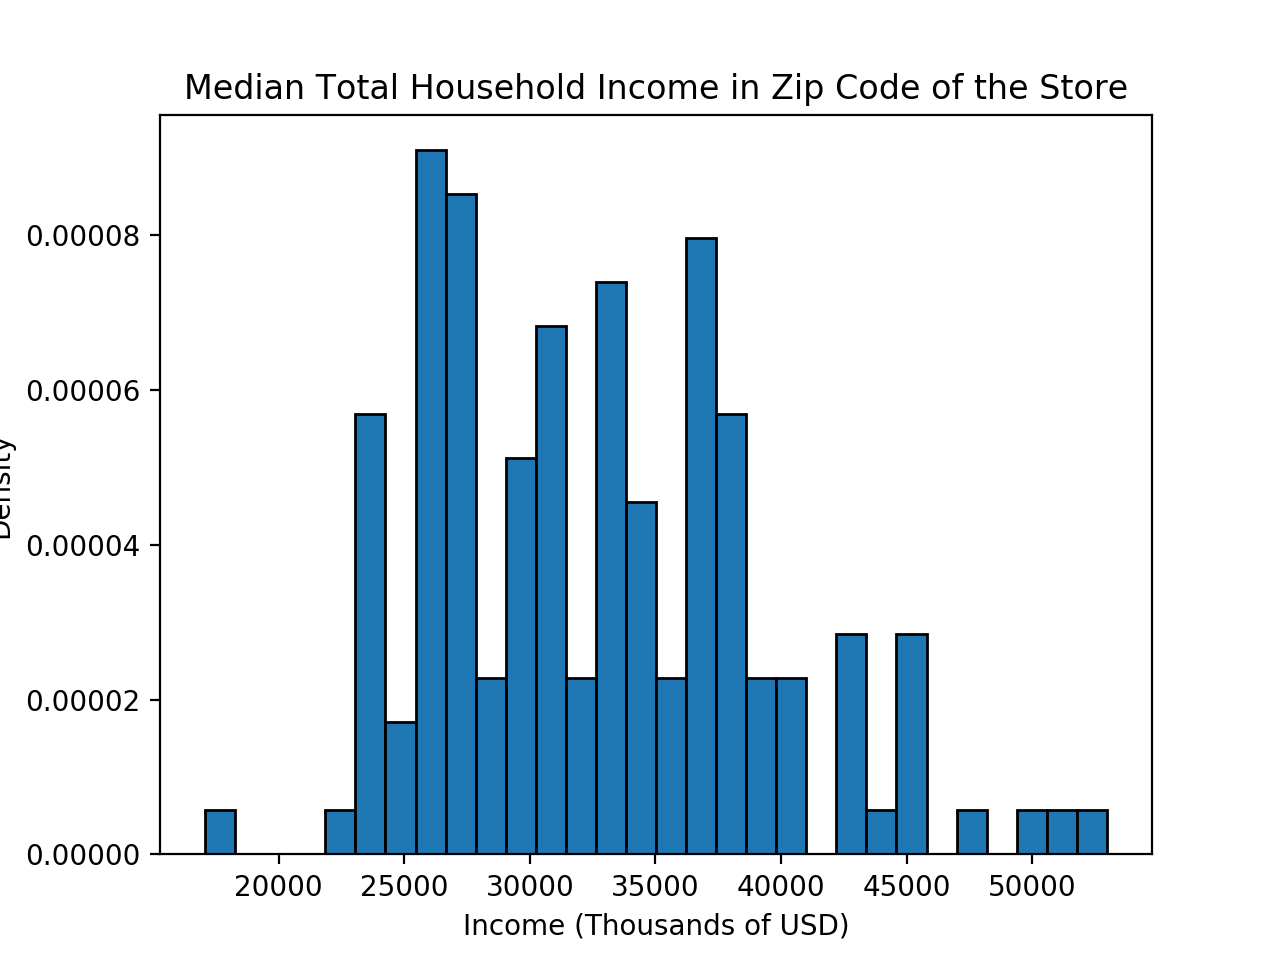

In [68]:
# histogram of med_income variable 
plt.hist(med_income, bins=30, edgecolor="black", normed=True)
plt.title("Median Total Household Income in Zip Code of the Store")
plt.xlabel("Income (Thousands of USD)")
plt.ylabel("Density")

1C) [5 points] Use maximum likelihood estimation to fit a lognormal distribution $LN(\mu, \sigma)$ to the median income data `medtotinc2010`. Report your estimated $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$. Report the standard error on the estimate for $\hat{\mu}_{mle}$.

In [83]:
# The lognormal pdf distribution function

def lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi))) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)) / prob_notcut
        
    return pdf_vals

In [84]:
# log-likelihood function

def log_lik(xvals, mu, sigma, cutoff):
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff) #calculate pdf_vals from the data
    ln_pdf_vals = np.log(pdf_vals) #take the log of those values
    log_lik_val = ln_pdf_vals.sum() #sum the log values 
    
    return log_lik_val

In [85]:
# The criterion function

def crit(params, *args):
    mu, sigma = params #these are the values we are trying to maximize
    xvals, cutoff = args #tuple of variable length arguments
    log_lik_value = log_lik(xvals, mu, sigma, cutoff)
    
    return log_lik_value

In [92]:
# initial guesses of values for parameters that maximize criterion function
#mu_init = 10.4
#sig_init = 2.8
mu_init = 33000
sig_init = 2500
params_init = np.array([mu_init, sig_init])

mle_args = (med_income, 100000) #tuple of arguments needed to solve critereon function, args are data and cutoff
results = opt.minimize(crit, params_init, args= mle_args, bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 33000.7756171  sig_MLE= 2489.8200258


/Users/kevinsun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/kevinsun/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [87]:
print("The Maximum Likelihood Estimate (MLE) for mu is:", mu_MLE)
print()
print("The Maximum Likelihood Estimate (MLE) for sigma is:", sig_MLE)
print()
print("The value for the log-likelihood function is:", log_lik(med_income, mu_MLE, sig_MLE, 100000))

The Maximum Likelihood Estimate (MLE) for mu is: 96024.8355113

The Maximum Likelihood Estimate (MLE) for sigma is: 2103.67951735

The value for the log-likelihood function is: -inf


/Users/kevinsun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [93]:
# VCV Matrix Calculation
OffDiagNeg = np.array([[1, -1], [-1, 1]]) # dimensions should equal number of parameters (2 parameters = 2x2 matrix)
vcv_mle = results.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE):')
print(vcv_mle)
print()
print('Standard error for mu estimate = ', stderr_mu_mle)
print()
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE):
[[ 1. -1.]
 [-1.  1.]]

Standard error for mu estimate =  1.0

Standard error for sigma estimate =  1.0


1D) [2 points] Plot the predicted distribution from your maximum likelihood estimates $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ against the histogram of the data.

<IPython.core.display.Javascript object>


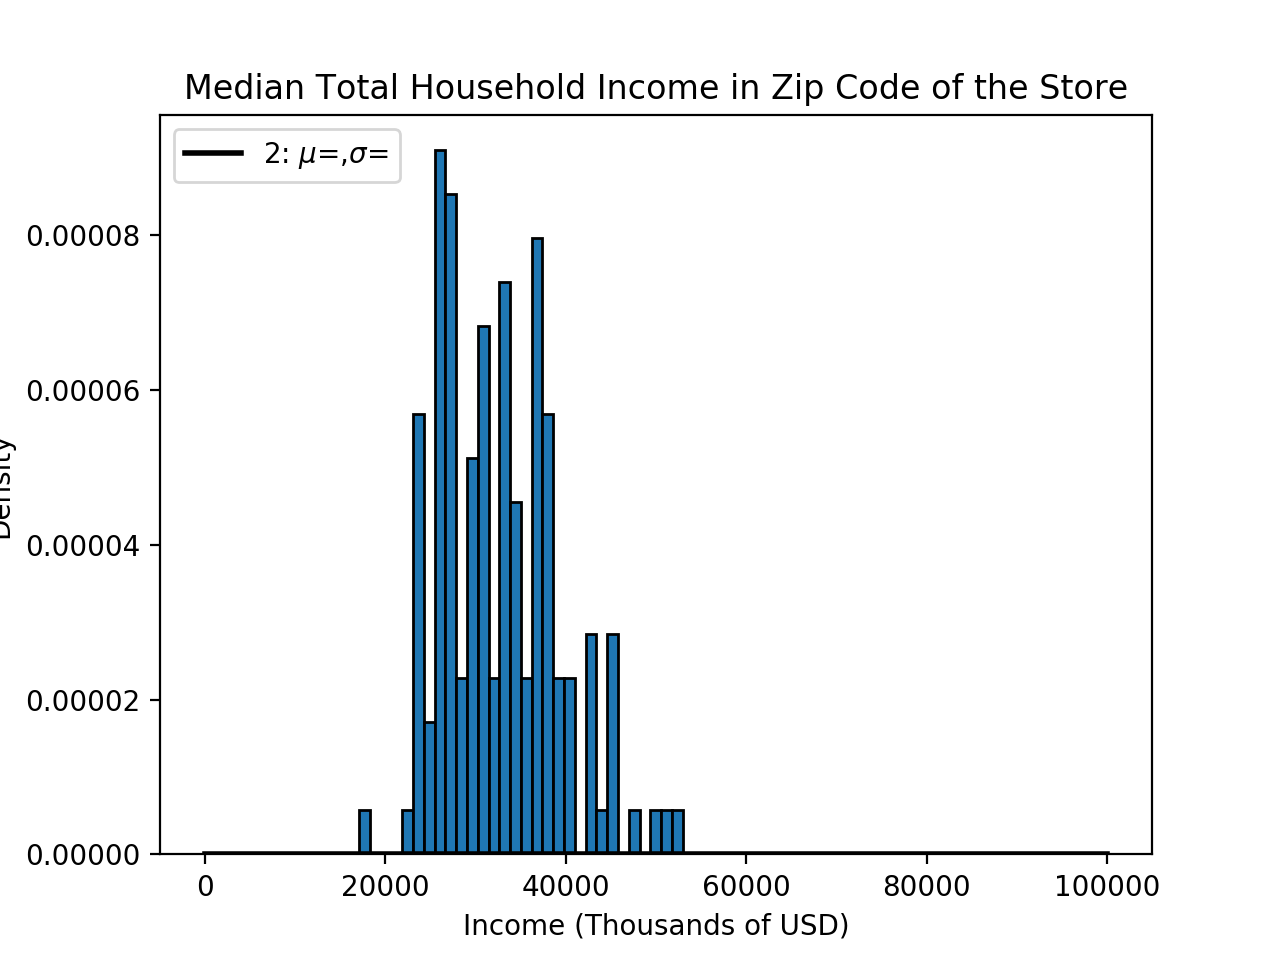

In [94]:
# histogram of med_income variable 
plt.hist(med_income, bins=30, edgecolor="black", normed=True)
plt.title("Median Total Household Income in Zip Code of the Store")
plt.xlabel("Income (Thousands of USD)")
plt.ylabel("Density")

dist_pts = np.linspace(0.1, 100000, 500)
# plot predicted distribution from mle 
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 100000),
         linewidth=2, color='k', label='2: $\mu$=,$\sigma$=')
plt.legend(loc='upper left')

## 2. Determinants of lender interest rates (10 points)

2A) [3 points] Assume a simple regression model of four factors that influence the interest rates that a lender charges, namely, number of stores, default rate in the area, unemployment rate in the area, and median household income in the area.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + u_i $$

Estimate this model by OLS using the `statsmodels.api` package. Don't forget to include a constant. Print your results summary. Which variables are significant at the 5-percent level? How would you interpret in words the estimated coefficient on `numstores`?

In [110]:
# create constant
lender_data['constant'] = 1

In [112]:
regression = sm.OLS(endog=lender_data['avgrate'], exog= lender_data[['constant', 'numstores', 'defrate', \
                                                                     'unrt_zip', 'medtotinc2010']], missing='drop')
ols_results1 = regression.fit()
print(ols_results1.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.375
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00229
Time:                        12:39:14   Log-Likelihood:                -812.28
No. Observations:                 147   AIC:                             1635.
Df Residuals:                     142   BIC:                             1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant        453.4117     51.263      8.845

#### Answer & Interpretation
At the 5% significance level, only numstores (number of other stores owned by the same owner) is statistically significant. The coefficient on numstores is negative. This that for every single additional store owned by a particular owner (if they were to own more than one store), the average annualized interest rate drops by 2.62%. 

2B) [4 points] Now assume a richer model for the determinants of lender interest rates, which includes the following measures of competition and other demographic variables.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + ... $$
$$ \qquad\qquad\qquad\qquad \beta_5 totrad3_i + \beta_6 edbachplus\_zip_i + \beta_7 pop\_zip_i + \beta_8 mdage\_zip_i + \beta_9 pctblk2\_zip_i + u_i $$

Estimate this regression by OLS using the `statsmodels.api` package. In controlling for these new varaibles, do any of the originally estimated coefficients from the model in part (2A) become statistically not significant (at the 5 percent level)? Of these new coefficients ($\beta_5$ through $\beta_9$), which one(s) are the most statistically significant?

In [115]:
regression = sm.OLS(endog=lender_data['avgrate'], exog= lender_data[['constant', 'numstores', 'defrate', \
                                                                     'unrt_zip', 'medtotinc2010', 'totrad3',\
                                                                    'edbachplus_zip', 'pop_zip', 'mdage_zip',\
                                                                    'pctblk2_zip']], missing='drop')
ols_results2 = regression.fit()
print(ols_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.846
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00419
Time:                        12:41:15   Log-Likelihood:                -808.23
No. Observations:                 147   AIC:                             1636.
Df Residuals:                     137   BIC:                             1666.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
constant         613.9741     85.491      7.

#### Answer and Interpretation
Compared to the first OLS regression we ran, *numstores* continues to be statistically significant at the 5% level while *defrate*, *unrt_zip*, and *medtotinc2010* remain statistically insignificant at the 5% level. Of the variables added, only the coefficient for *edbachplius_zip* is statistically significant at the 5% level and therefore, the most statistically significant of all of the new variables added.

2C) [3 points] Create a new binary variable called `avgrate_high` that equals 1 if `avgrate` > 490, and equals 0 otherwise. Estimate a logistic regression using the `statsmodels.api` package. Let $X\beta$ be the linear coefficients and variables from the model from part (2B).

$$ Pr(avgrate\_high=1|X\beta) = \frac{X\beta}{1 + X\beta} $$

Report the variables whose coefficients are estimated to be significant at the 5-percent level.

In [148]:
# CORRECTION BY DR. EVANS:
# dummy variable cutoff needs to be at >= 425
# drop variable that gives measure of competition (totrad3) 

In [149]:
#avgrate_high = lender_data['avgrate']
#avgrate_high = np.array(avgrate_high)

# make binary avgrate_high variable and add to data frame
#avgrate_high_list = []
#for value in avgrate_high:
    #if value >= 425:
       # value = 1
        #avgrate_high_list.append(value)
    #else:
       # value = 0
        #avgrate_high_list.append(value)

#lender_data['avgrate_high'] = avgrate_high_list
#lender_data.head(10)

In [151]:
# drop totrad3 from the data frame
lender_data.drop(['totrad3'],1)
lender_data.drop(['avgrate_high'],1)

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip,constant
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0,1
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2,1
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2,1
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4,1
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7,1
5,521.429993,23,28.148958,21,15,38,7.5,27502.00000,22.3,28936,30.8,2.7,1
6,521.429993,23,34.020618,21,15,38,10.8,24939.33398,14.8,33297,28.9,5.6,1
7,521.429993,23,22.362869,15,7,23,7.4,34078.60938,23.5,35603,29.1,1.6,1
8,521.429993,23,25.284090,18,6,24,9.9,23155.38867,11.1,24869,27.5,5.1,1
9,521.429993,23,37.777779,28,14,43,9.9,23155.38867,11.1,24869,27.5,5.1,1


In [152]:
def make_binary(avgrate):
    if avgrate >= 425:
        avgrate = 1
    else:
        avgrate = 0
    return make_binary

lender_data["avgrate_high"] = lender_data["avgrate"].apply(make_binary)


In [154]:
# run logit regression
exog_var = ['constant', 'numstores', 'defrate', 'unrt_zip', 'medtotinc2010', 'totrad3',\
             'edbachplus_zip', 'pop_zip', 'mdage_zip','pctblk2_zip']

Logit_Model = sm.Logit(endog = lender_data["avgrate_high"], exog = lender_data[exog_var])
result = Logit_Model.fit()
result.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).